# POS

In [4]:
pair_list=['ADA',
 'ALGO',
'ANT',
          'ATOM',
          'DOT','EOS','ICX','NEO']

In [6]:
# align all data
data_price = pd.DataFrame()
for symbol in pair_list:
    data = pd.read_pickle('{0}/{1}.pkl'.format(market_data_folder_1h, symbol))
    data_price = pd.concat([data_price, data.close], axis=1)
data_price.columns = pair_list
data_price.to_pickle('{}/pair_combined_close_pos.pkl'.format(market_data_folder_1h))

In [7]:
data_price

,ADA,ALGO,ANT,ATOM,DOT,EOS,ICX,NEO
2018-11-01 00:00:00,0.070607,NaN,NaN,NaN,NaN,5.2616,NaN,15.45
2018-11-01 01:00:00,0.070276,NaN,NaN,NaN,NaN,5.2513,NaN,15.36
2018-11-01 02:00:00,0.070573,NaN,NaN,NaN,NaN,5.2597,NaN,15.41
2018-11-01 03:00:00,0.070621,NaN,NaN,NaN,NaN,5.2675,NaN,15.43
2018-11-01 04:00:00,0.070619,NaN,NaN,NaN,NaN,5.2686,NaN,15.42
...,...,...,...,...,...,...,...,...
2021-01-13 20:00:00,0.290517,0.4243,3.1337,5.9112,9.1598,2.6650,0.5866,21.96
2021-01-13 21:00:00,0.290792,0.4259,3.1798,5.9216,9.4855,2.6871,0.5942,21.94
2021-01-13 22:00:00,0.285946,0.4190,3.1474,5.9061,9.5698,2.6602,0.5819,21.66
2021-01-13 23:00:00,0.290666,0.4355,3.1929,5.9567,9.6800,2.7002,0.5905,21.93


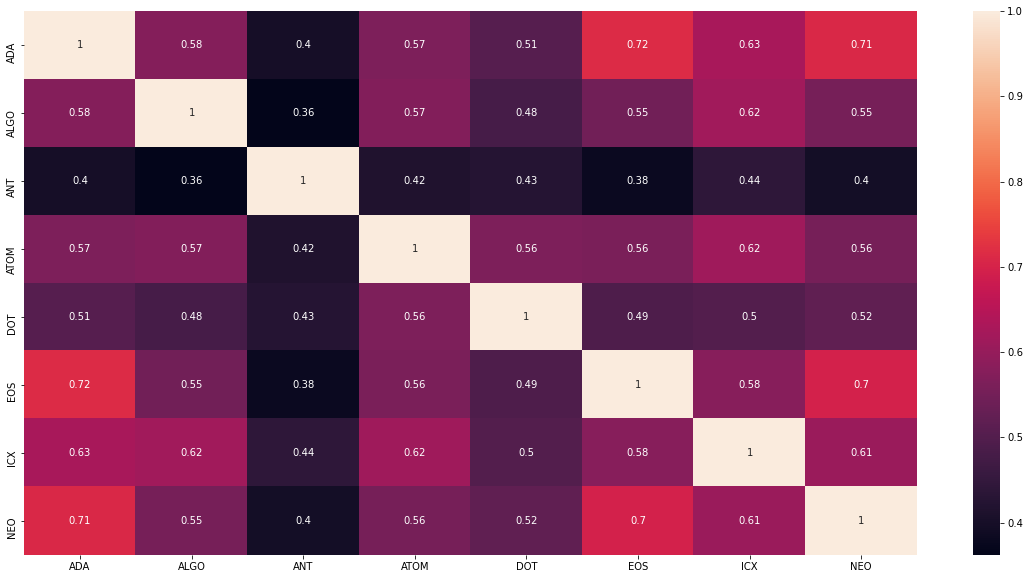

In [8]:
dt = data_price.pct_change()
corrMatrix = dt.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [9]:
def cal_ols(data,adf_threshold=-2):
    
    x = data.iloc[:,0]
    y = data.iloc[:,1] 

    if x.isnull().sum(axis = 0) > 0 or y.isnull().sum(axis = 0) > 0:
        return float('NaN'),float('NaN'),float('NaN')
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    results = model.fit()
    influence = results.get_influence()
    result = adfuller(results.resid)
    
    beta = results.params[1]
    d = adf_threshold - result[0]
    sr = influence.resid_studentized_internal[-1]
    asr = abs(sr)
    ps = asr**d
    return beta,sr,ps

In [10]:
def cal_factor(data,adf_threshold, window_size):
    factor = pd.DataFrame(index = data.index, columns = ['beta','sr','ps'])
    for i in range(window_size-1,len(data)):
        factor.iloc[i,0], factor.iloc[i,1], factor.iloc[i,2] = cal_ols(data.iloc[i+1-window_size:i+1,:])
    return factor

In [11]:
def backtest_frequency(freq = 1, use_pnl = True):
    ####
    start_index = 0
    data_price = pd.read_pickle('{}/pair_combined_close_pos.pkl'.format(market_data_folder_1h))
    data_price = data_price[start_index:-1:freq]

    ####
    factors = {}

    if use_pnl:
        for i in range(0,len(pair_list)):
            factors[pair_list[i]] = {}
            for j in range(i+1,len(pair_list)):
                data_combine = data_price[[pair_list[i],pair_list[j]]]
                factors[pair_list[i]][pair_list[j]] = cal_factor(data_combine.pct_change(),-2, int((24/freq) * 60))
#                 print(pair_list[i],pair_list[j])
    else:
        for i in range(0,len(pair_list)):
            factors[pair_list[i]] = {}
            for j in range(i+1,len(pair_list)):
                data_combine = data_price[[pair_list[i],pair_list[j]]]
                factors[pair_list[i]][pair_list[j]] = cal_factor(data_combine,-2,int((24/freq) * 30))
#                 print(pair_list[i],pair_list[j])    
    ####        
    pos = pd.DataFrame(0,index = data_price.index, columns = pair_list)
    threshold = 1.5
    for i in range(len(pair_list)):
        for j in range(i+1,len(pair_list)):
            ###### factors for the pair ##########

            pair_x = pair_list[i]
            pair_y = pair_list[j]
            sr = factors[pair_x][pair_y].loc[:,'sr']
            ps = factors[pair_x][pair_y].loc[:,'ps']
            beta = factors[pair_x][pair_y].loc[:,'beta']

            ###### Long / Short trigers ##########
            ps_ema = ps.ewm(span = 14).mean()
            pos_l = ((sr > 0) & (ps > threshold)).astype(int)
            pos_s = -((sr < 0) & (ps > threshold)).astype(int)
            pos_x = pos_l +  pos_s          

            ##### Calculate the positions ########

            temp_beta1 = (beta * pos_x).fillna(0)
            pos.loc[:,pair_x] += temp_beta1 

            temp_beta2 = (-pos_x).fillna(0)
            pos.loc[:,pair_y] += temp_beta2 
    data_price_4h = data_price
    target_portfolio_4h = pos.copy()

    ########################## use 1h data ####################################
    data_price_1h = pd.read_pickle('{}/pair_combined_close_pos.pkl'.format(market_data_folder_1h))
    if use_pnl:
        target_portfolio_4h_share = target_portfolio_4h/data_price_4h # combined
    else:
        target_portfolio_4h_share = target_portfolio_4h

    target_portfolio_4h_share.fillna(0, inplace=True)

    
    
    ################
    
    temp_df = pd.DataFrame(index=data_price_1h[0:-1:8].index)
    target_portfolio_4h_share = pd.concat([target_portfolio_4h_share, temp_df], axis=1, join='inner')
    target_portfolio_4h_share.ffill(inplace=True)
    target_portfolio_4h_share.fillna(0, inplace=True)   
    
    #################

    temp_df = pd.DataFrame(index=data_price_1h.index)
    target_portfolio_4h_share = pd.concat([target_portfolio_4h_share, temp_df], axis=1)
    target_portfolio_4h_share.ffill(inplace=True)
    target_portfolio_4h_share.fillna(0,
                                     inplace=True)

    # 
    bt_result_4h = bt.backtest(data_price_1h,
                            target_portfolio_4h_share,
                            target_as_share=True,
                            cost_bps=0,  # trading cost model in bps
                            fin_bps=0.0,  # financial cost model in bps
                            delay_day_execution=0)  # need to change to 1 if want to test for result 1 hour delay
                            # delay_day_execution=1)  # need to change to 1 if want to test for result 1 hour delay
    bt_stats_all_4h = ba.statistics(bt_result_4h, trading_bars_year=365 * 24)
    print(bt_stats_all_4h)
    ba.plot_pnl_portfolio(bt_result_4h, title="combined portfolio pnl - 1h data")
    plt.show()     
    return None

In [ ]:
backtest_frequency(freq = 1, use_pnl = True)

index                 All         2018        2019       2020       2021
ret_pct           323.19%       28.95%     304.69%    350.37%    139.36%
ret_pct_maxbs      29.44%        0.08%      49.26%     48.41%     88.84%
volat_pct         114.36%      117.73%      97.85%     89.63%     78.44%
sharpe            2.82606     0.245904     3.11374    3.90931     1.7767
tvr               1.01474    0.0050651     0.50834    1.53472    5.75285
tvr_rate            41.4%       49.98%      43.94%     41.28%     36.97%
rot_bps           8.91113     0.661268     7.91644    9.68869     4.3036
daily_pnl       0.0217019  8.03853e-06  0.00965819  0.0356866  0.0594192
daily_volat      0.146711  0.000624537   0.0592598   0.174402   0.638939
mdd               -1.6798      -0.0037     -1.1716     -1.396    -1.2456
booksize            2.451       0.0101       1.157     3.7177    15.5626
abs_booksize        2.451       0.0101       1.157     3.7177    15.5626
max_booksize      26.9044         3.72      7.1568 

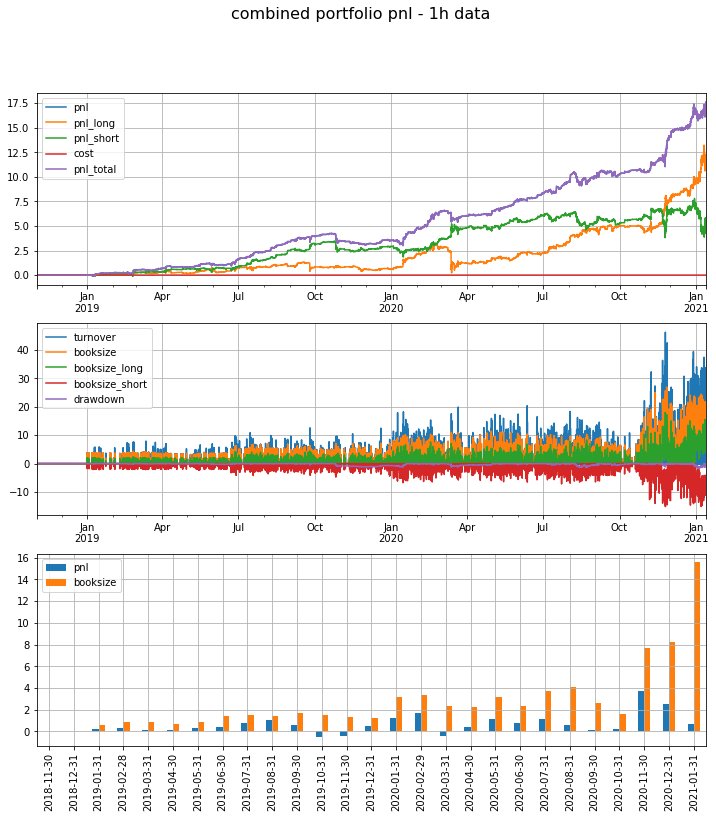

In [44]:
backtest_frequency(freq = 4, use_pnl = True)

index                  All         2018        2019        2020      2021
ret_pct             92.66%      151.38%      48.56%      12.88%   924.15%
ret_pct_maxbs        8.76%        0.82%       8.16%       2.02%   463.26%
volat_pct          116.01%      278.36%     106.77%      96.13%    74.19%
sharpe            0.798719     0.543846     0.45484    0.133991   12.4565
tvr               0.502514   0.00266983     0.26366    0.758703    2.5477
tvr_rate            20.43%       25.08%      21.73%      20.16%    19.53%
rot_bps            5.17683      6.89021     2.55155    0.729267   54.0065
daily_pnl       0.00624343  4.41497e-05  0.00161458  0.00132791  0.330222
daily_volat        0.14934   0.00155095   0.0678182    0.189339  0.506472
mdd                -2.9539      -0.0123     -0.8993     -2.9539   -0.7127
booksize            2.4594       0.0106      1.2135       3.763   13.0424
abs_booksize        2.4594       0.0106      1.2135       3.763   13.0424
max_booksize       26.0181       1.963

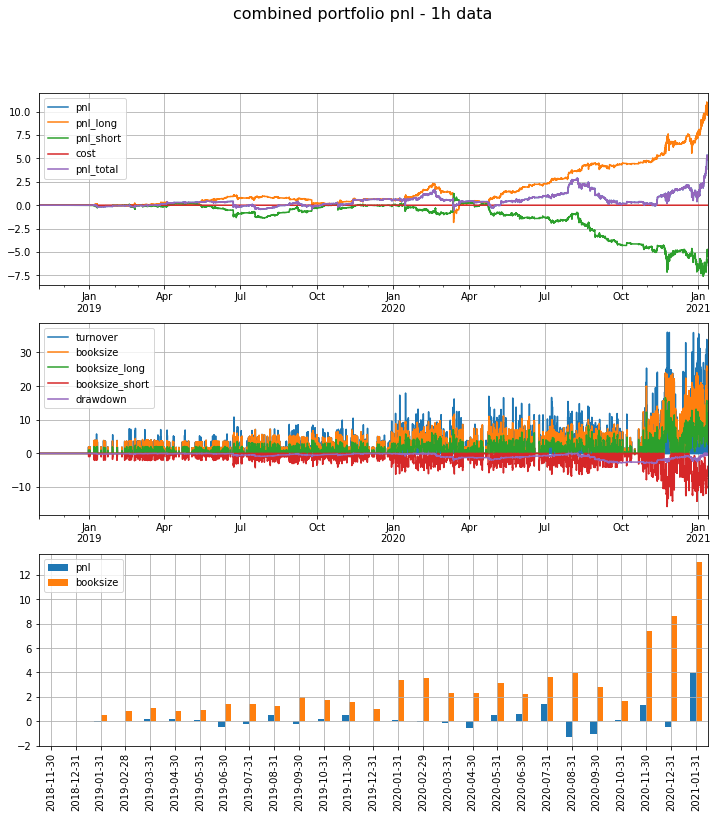

In [45]:
backtest_frequency(freq = 8, use_pnl = True)

index                  All        2018        2019        2020       2021
ret_pct             33.92%      45.99%      64.84%      39.73%   -261.98%
ret_pct_maxbs        6.73%      14.24%      18.59%      11.56%    -133.2%
volat_pct           52.78%      61.17%      50.07%      44.76%     65.28%
sharpe            0.642787    0.751766     1.29509    0.887605   -4.01305
tvr                 0.4886    0.194371    0.301783    0.704913    1.12125
tvr_rate            12.48%      12.99%      12.84%      12.41%     11.16%
rot_bps            3.10429     4.04071     5.76424     3.65454   -26.7878
daily_pnl       0.00364021  0.00188496  0.00417492  0.00618271 -0.0720861
daily_volat       0.108195   0.0479032   0.0615876    0.133078   0.343181
mdd                 -2.141     -0.2357     -1.3612     -1.9052    -1.6574
booksize            3.9166      1.4962      2.3501      5.6801    10.0434
abs_booksize        3.9166      1.4962      2.3501      5.6801    10.0434
max_booksize       19.7527      4.8314

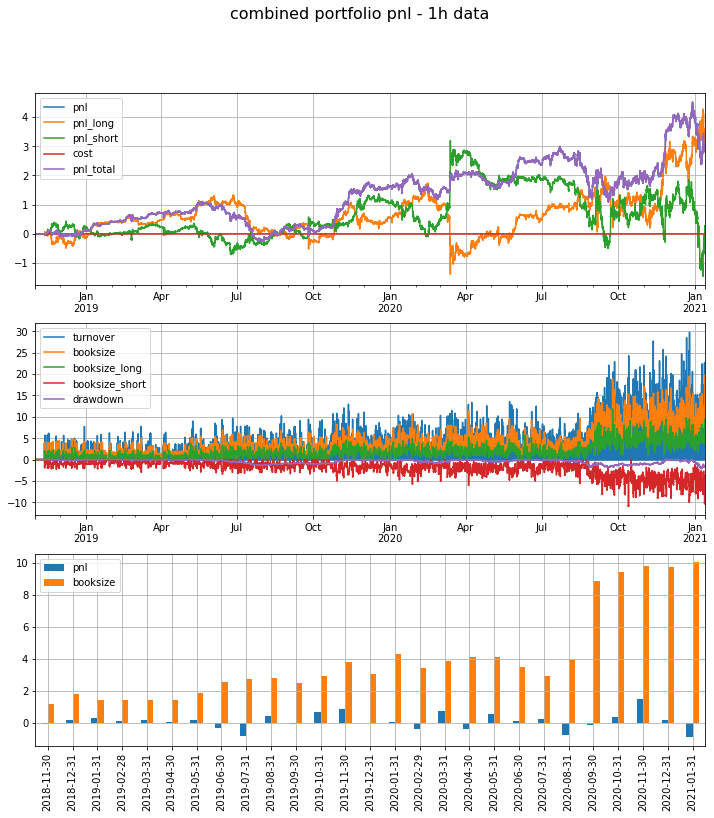

In [23]:
backtest_frequency(freq = 12, use_pnl = True)

index                 All        2018        2019         2020       2021
ret_pct           -20.81%     -173.8%       29.7%       -8.71%   -733.04%
ret_pct_maxbs      -3.18%     -38.41%       6.77%       -1.93%    -268.1%
volat_pct          62.63%      87.42%      57.91%       51.17%    126.68%
sharpe          -0.332329    -1.98804    0.512847    -0.170229   -5.78664
tvr              0.190118   0.0707193     0.12612     0.271323   0.349803
tvr_rate            6.71%       7.13%       7.04%        6.61%      7.06%
rot_bps           -3.5386    -27.8431     4.81666     -1.50448   -118.505
daily_pnl      -0.0016146 -0.00472571  0.00145794 -0.000979679 -0.0994879
daily_volat     0.0928206   0.0454137   0.0543125      0.10995   0.328466
mdd               -2.5002     -0.5019     -0.7352      -1.8531    -1.3352
booksize           2.8316      0.9924      1.7918       4.1055     4.9538
abs_booksize       2.8316      0.9924      1.7918       4.1055     4.9538
max_booksize      18.5227      4.4904 

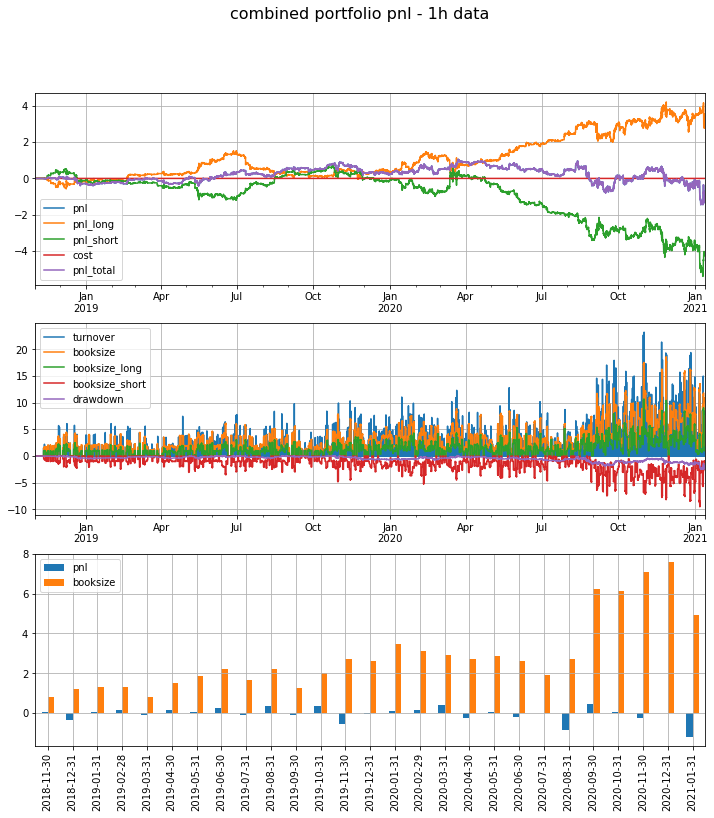

In [24]:
backtest_frequency(freq = 24, use_pnl = True)

index                 All       2018      2019       2020      2021
ret_pct            129.6%    521.04%   137.54%    191.02%  -912.08%
ret_pct_maxbs        6.4%     38.79%     8.88%     13.88%  -202.39%
volat_pct         135.57%    122.14%   113.97%    108.82%   165.51%
sharpe           0.955947    4.26592   1.20688    1.75535  -5.51077
tvr               5.74095    1.65902   3.26488    8.45525   18.9376
tvr_rate           61.28%     53.38%    62.31%     61.33%    59.52%
rot_bps           2.41428     11.143   2.51974    3.55577  -17.4918
daily_pnl       0.0332646  0.0443677  0.019744  0.0721558 -0.795008
daily_volat      0.664806   0.198701  0.312549   0.785335   2.75617
mdd              -32.1448    -0.9921   -4.1955   -32.1448  -14.2163
booksize           9.3685     3.1081    5.2395    13.7875    31.815
abs_booksize       9.3685     3.1081    5.2395    13.7875    31.815
max_booksize      189.736    41.7432    81.145    189.736   143.376
min_booksize            0          0         0  

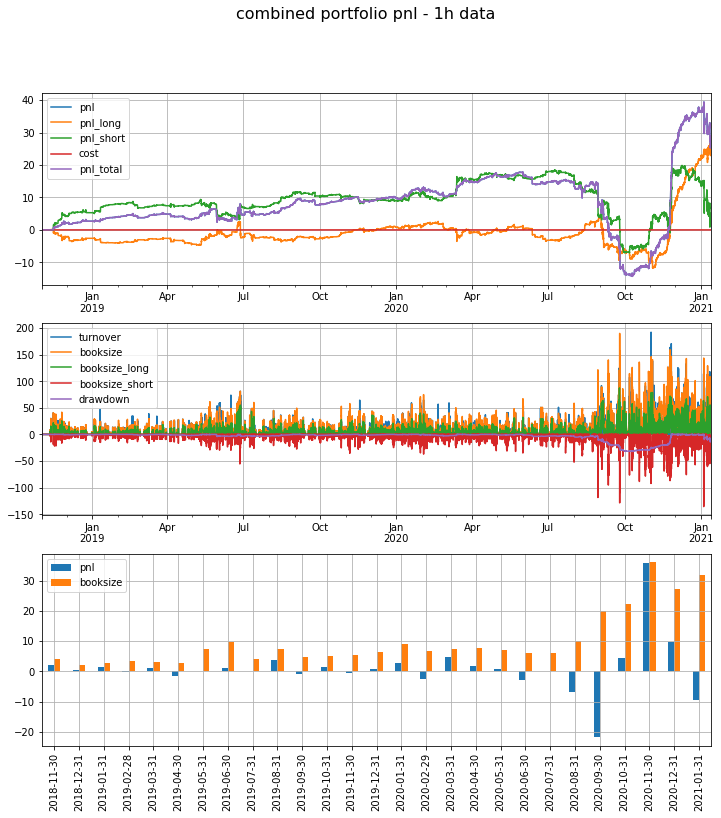

In [25]:
backtest_frequency(freq = 1, use_pnl = False)

index                 All       2018        2019       2020      2021
ret_pct           -78.19%    159.56%     -17.24%    -44.74%  -759.43%
ret_pct_maxbs      -4.13%      11.2%      -1.15%     -3.47%  -178.34%
volat_pct         125.33%    127.66%      116.3%     97.09%   130.04%
sharpe          -0.623867    1.24983    -0.14827  -0.460826  -5.83997
tvr               2.50096   0.682364     1.43391    3.62212   10.0182
tvr_rate           25.12%     24.63%      26.52%     24.75%    23.79%
rot_bps          -3.55312    7.39468    -0.74226   -2.06328  -36.4359
daily_pnl      -0.0213269  0.0121101 -0.00255439 -0.0179363 -0.876053
daily_volat      0.653102   0.185115     0.32914   0.743604   2.86594
mdd              -35.1014     -1.211     -5.5214    -34.772   -13.225
booksize           9.9554     2.7703      5.4067     14.632   42.1051
abs_booksize       9.9554     2.7703      5.4067     14.632   42.1051
max_booksize      188.634    39.4827     81.2014    188.634   179.301
min_booksize        

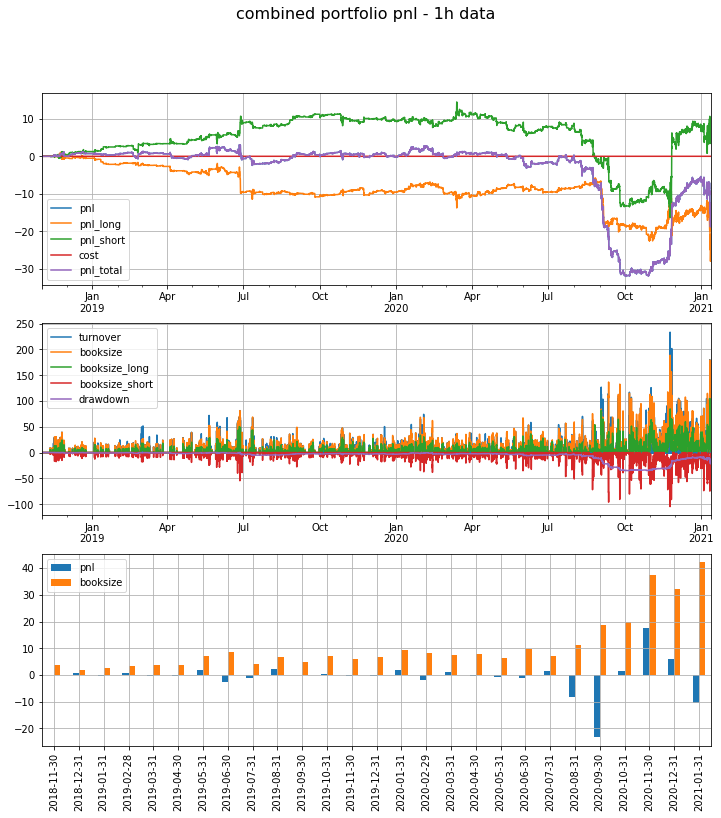

In [26]:
backtest_frequency(freq = 4, use_pnl = False)

index                  All         2018       2019        2020        2021
ret_pct            -20.53%        -0.7%    -75.39%      -3.26%       -5.3%
ret_pct_maxbs       -1.13%       -0.04%     -5.74%      -0.34%      -1.14%
volat_pct          108.35%      131.25%    111.35%      86.89%     105.32%
sharpe           -0.189482  -0.00530132  -0.677109  -0.0375484  -0.0502957
tvr                1.69184     0.398399   0.990978     2.44835     6.67149
tvr_rate             16.1%       16.25%     16.44%      15.99%      16.26%
rot_bps           -1.45576   -0.0488907   -5.23645   -0.232953   -0.371795
daily_pnl      -0.00591098 -4.67472e-05 -0.0124541 -0.00136885 -0.00595303
daily_volat       0.595989     0.168468   0.351398    0.696481     2.26128
mdd               -26.4298      -1.4289    -6.2298     -21.727     -5.0268
booksize           10.5089       2.4522     6.0294     15.3142     41.0209
abs_booksize       10.5089       2.4522     6.0294     15.3142     41.0209
max_booksize       190.66

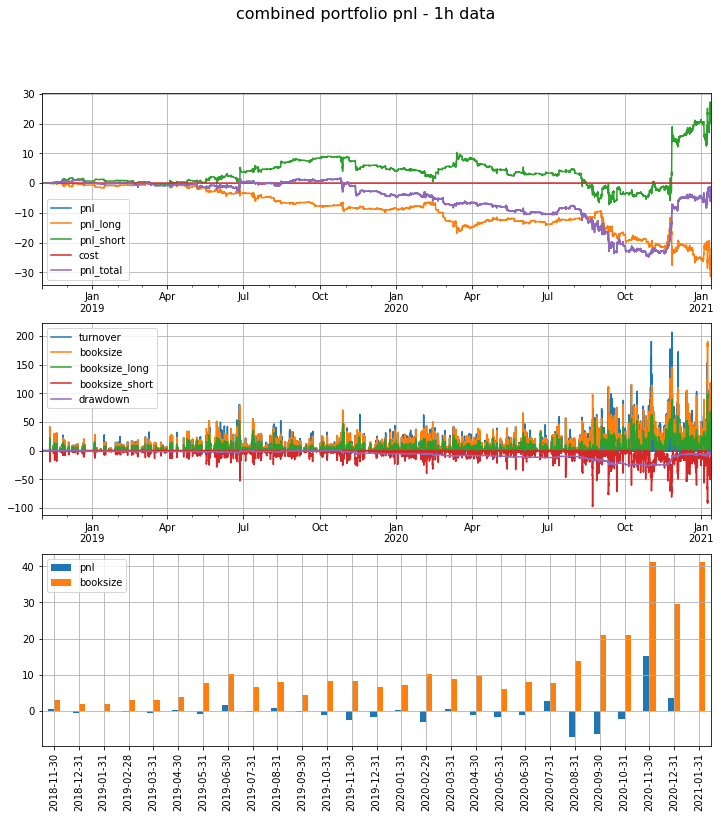

In [27]:
backtest_frequency(freq = 8, use_pnl = False)

index                   All       2018       2019         2020      2021
ret_pct              -1.05%     65.59%     32.33%        0.59%  -233.48%
ret_pct_maxbs        -0.13%      9.75%      5.18%        0.11%  -114.38%
volat_pct            77.59%     79.78%     71.91%       67.09%    80.69%
sharpe           -0.0135595   0.822178     0.4496   0.00877429  -2.89339
tvr                 2.45242   0.908987     1.4867      3.54006   6.67295
tvr_rate             11.47%     12.98%     11.74%       11.36%    10.89%
rot_bps           -0.104729    5.76849    3.14277    0.0591606  -24.4845
daily_pnl      -0.000616413  0.0125844  0.0112136  0.000502637 -0.392122
daily_volat        0.868507   0.292423   0.476504      1.09443   2.58917
mdd                -15.9828    -1.7765    -6.3321     -15.9828  -10.1048
booksize            21.3851     7.0028    12.6602      31.1642   61.3007
abs_booksize        21.3851     7.0028    12.6602      31.1642   61.3007
max_booksize        173.822    47.1011    78.9693  

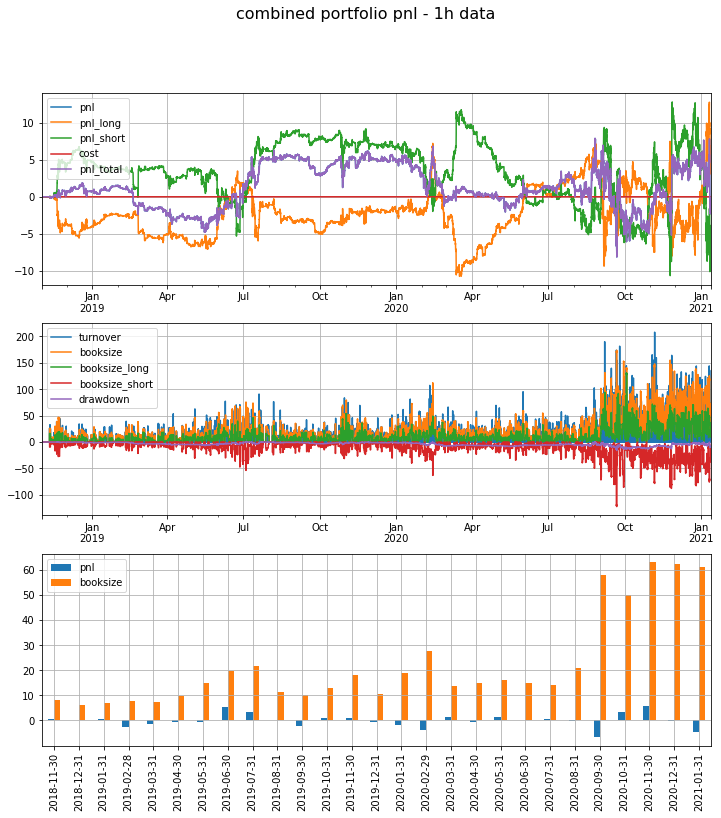

In [28]:
backtest_frequency(freq = 12, use_pnl = False)

index                 All       2018      2019       2020       2021
ret_pct          -156.24%   -188.34%   -72.62%    -94.13%  -1493.87%
ret_pct_maxbs      -14.0%    -27.52%    -6.91%    -11.75%   -534.48%
volat_pct          90.98%     99.61%    78.54%     78.42%    101.52%
sharpe            -1.7172   -1.89089 -0.924702   -1.20032   -14.7155
tvr                1.0468   0.293101  0.688895    1.46381    3.23963
tvr_rate            6.33%      6.57%     6.35%      6.36%      6.18%
rot_bps          -28.1627    -32.714  -13.0523   -16.9038   -275.977
daily_pnl      -0.0707538 -0.0230124  -0.02158 -0.0593853   -2.14576
daily_volat      0.787184    0.23251  0.445856   0.945208    2.78581
mdd              -58.7574    -2.1372  -14.8522   -23.5114    -25.984
booksize          16.5296     4.4597    10.846    23.0265    52.4278
abs_booksize      16.5296     4.4597    10.846    23.0265    52.4278
max_booksize      184.513    30.5194   113.959    184.513    146.536
min_booksize            0         

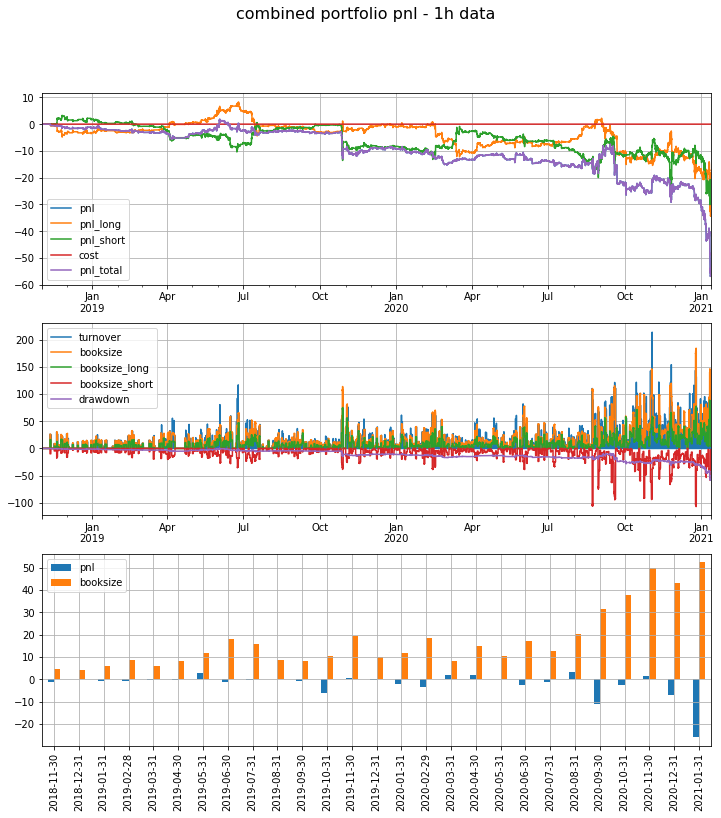

In [29]:
backtest_frequency(freq = 24, use_pnl = False)